# 3. Spending Score Classification

In this notebook, we ask the question whether we can classify the spending score for customers assuming we have no access to their segments. This information might be useful for the company in case they want to provide recommendations to customer, as they would be able to calibrate their suggestions and marketting of products according to the customers financial situation

In [183]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn import preprocessing
from sklearn import neighbors
from sklearn.metrics import r2_score 
import time
from dtreeviz.trees import dtreeviz
from sklearn.metrics import cohen_kappa_score


In [184]:
X_train=pd.read_csv("data-income/X_train.csv", index_col=0)
y_train=pd.read_csv("data-income/y_train.csv", index_col=0)

X_test=pd.read_csv("data-income/X_test.csv", index_col=0)
y_test=pd.read_csv("data-income/y_test.csv", index_col=0)

In [185]:
X_train

,Age,Work_Experience,Family_Size,Gender_Male,Ever_Married_Yes,Graduated_Yes,Profession_Doctor,Profession_Engineer,Profession_Entertainment,Profession_Executive,Profession_Healthcare,Profession_Homemaker,Profession_Lawyer,Profession_Marketing,Var_1_Cat_2,Var_1_Cat_3,Var_1_Cat_4,Var_1_Cat_5,Var_1_Cat_6,Var_1_Cat_7
0,22,1.0,4.0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
2,67,1.0,1.0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0
3,67,0.0,2.0,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0
5,56,0.0,2.0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
6,32,1.0,3.0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8062,41,0.0,5.0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
8064,35,3.0,4.0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
8065,33,1.0,1.0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0
8066,27,1.0,4.0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0


In [186]:
# measure mutual information
from sklearn.feature_selection import mutual_info_classif as MIC
mi_score = MIC(X_train,y_train.values.ravel())
print(mi_score)

[0.15102135 0.         0.10865494 0.01369205 0.29741931 0.01948959
 0.         0.0037312  0.         0.05420617 0.04231705 0.00546096
 0.03750442 0.00732711 0.00469452 0.00397383 0.         0.00511408
 0.00069487 0.0114797 ]


In [187]:
sorted_feats=[]
for score, f_name in sorted(zip(mi_score, X_train.columns), reverse=True):
        print(f_name, score)
        sorted_feats.append(f_name)
mic = X_train[sorted_feats]
print(mic.columns)

Ever_Married_Yes 0.2974193130810545
Age 0.15102134904583475
Family_Size 0.10865494398921394
Profession_Executive 0.054206166286934865
Profession_Healthcare 0.042317047265576946
Profession_Lawyer 0.03750442366020357
Graduated_Yes 0.019489592414481338
Gender_Male 0.013692054180972635
Var_1_Cat_7 0.011479699915842856
Profession_Marketing 0.007327109106344709
Profession_Homemaker 0.005460956750351409
Var_1_Cat_5 0.005114076270495982
Var_1_Cat_2 0.004694516437905305
Var_1_Cat_3 0.003973832482414341
Profession_Engineer 0.003731197809365483
Var_1_Cat_6 0.000694868843150509
Work_Experience 0.0
Var_1_Cat_4 0.0
Profession_Entertainment 0.0
Profession_Doctor 0.0
Index(['Ever_Married_Yes', 'Age', 'Family_Size', 'Profession_Executive',
       'Profession_Healthcare', 'Profession_Lawyer', 'Graduated_Yes',
       'Gender_Male', 'Var_1_Cat_7', 'Profession_Marketing',
       'Profession_Homemaker', 'Var_1_Cat_5', 'Var_1_Cat_2', 'Var_1_Cat_3',
       'Profession_Engineer', 'Var_1_Cat_6', 'Work_Experienc

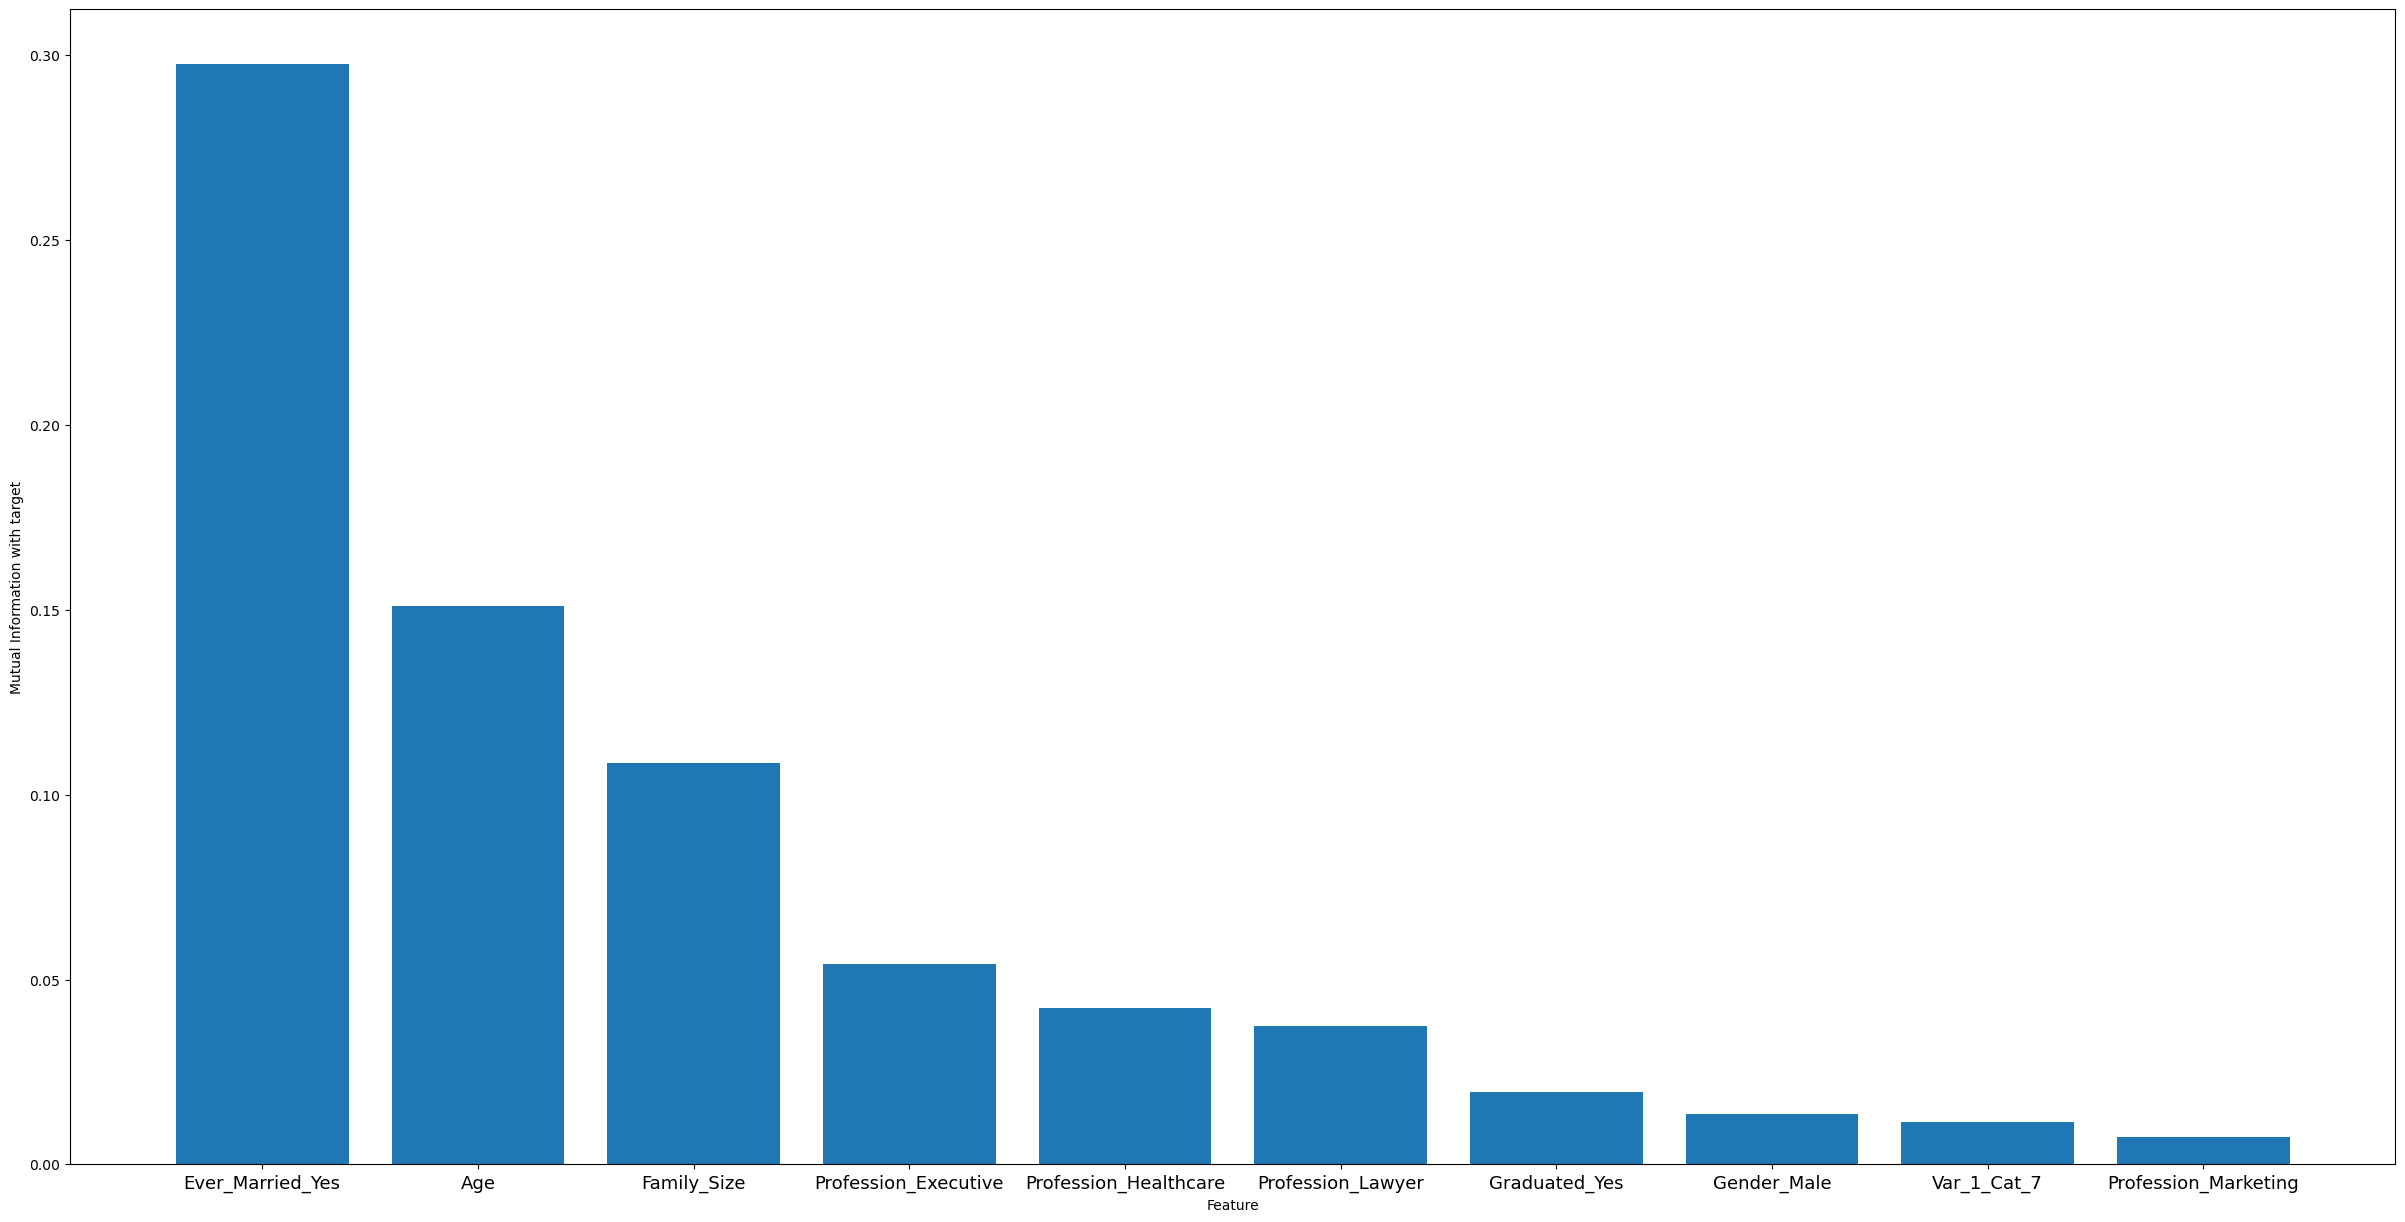

In [227]:
plt.figure(figsize=(30,15))
plt.bar(mic.columns[:10], sorted(mi_score, reverse=True)[:10])
plt.xlabel("Feature")
plt.tick_params(axis='x', which='major', labelsize=13)
plt.ylabel("Mutual Information with target")
plt.show()

According to MI, being married, age and family size give us the most information about the spending score

In [189]:
label_map={"Low":0, "Average":1, "High":2}

In [190]:
# Look at correlation
df=pd.concat([X_train,y_train['Spending_Score'].map(label_map)], axis=1)
corr_matrix = df.corr()
print(corr_matrix["Spending_Score"].sort_values(ascending=False))
df=corr_matrix["Spending_Score"].sort_values(ascending=False)

Spending_Score              1.000000
Ever_Married_Yes            0.617433
Age                         0.432261
Profession_Executive        0.358155
Profession_Lawyer           0.214281
Graduated_Yes               0.114328
Family_Size                 0.095669
Var_1_Cat_6                 0.091581
Gender_Male                 0.068140
Var_1_Cat_7                -0.012225
Var_1_Cat_5                -0.013042
Profession_Homemaker       -0.019459
Profession_Engineer        -0.030472
Var_1_Cat_4                -0.031282
Var_1_Cat_2                -0.034257
Profession_Entertainment   -0.066033
Var_1_Cat_3                -0.066349
Work_Experience            -0.077021
Profession_Marketing       -0.077522
Profession_Doctor          -0.085421
Profession_Healthcare      -0.267461
Name: Spending_Score, dtype: float64


In [191]:
df=df[abs(df)>0.1]

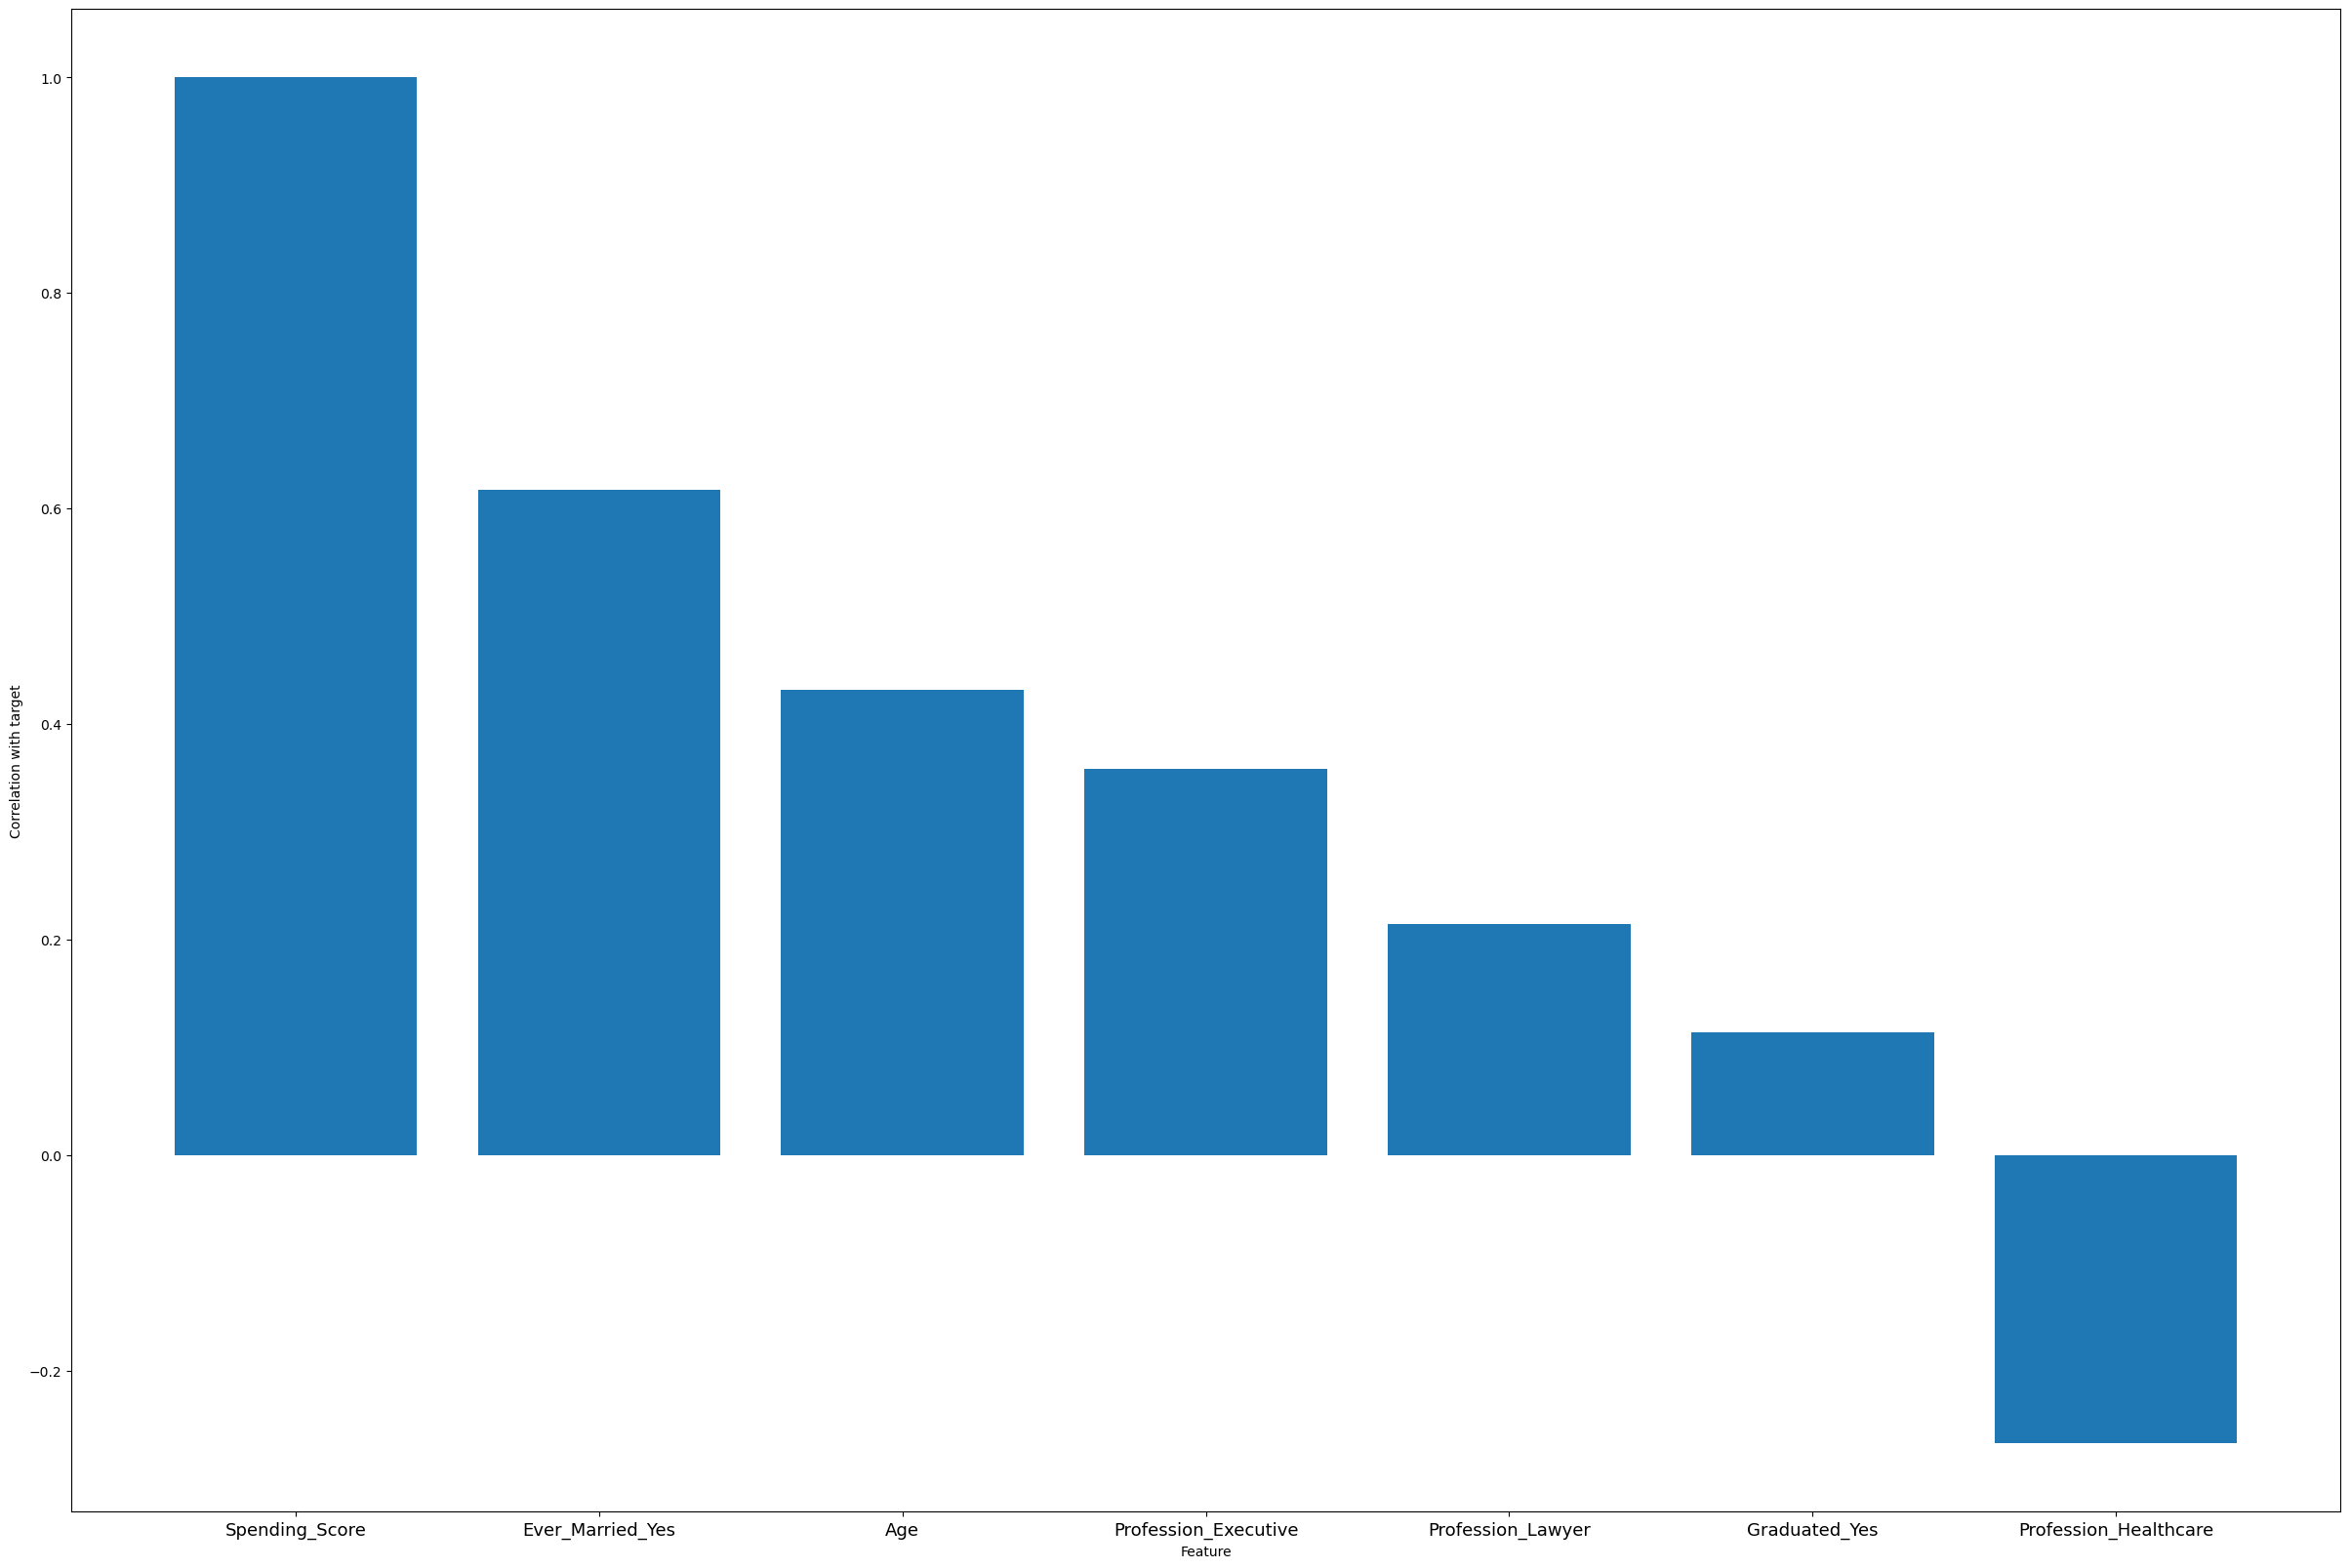

In [192]:
plt.figure(figsize=(30,20))
plt.bar(df.index, df.values)
plt.xlabel("Feature")
plt.tick_params(axis='x', which='major', labelsize=13)
plt.ylabel("Correlation with target")
plt.show()

<AxesSubplot:>

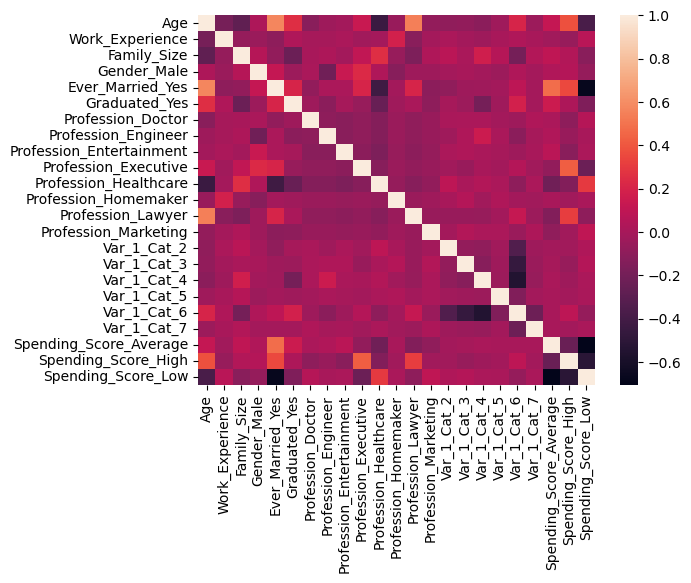

In [193]:
pd.get_dummies(y_train, columns=['Spending_Score'])
# Look at correlation
df=pd.concat([X_train,pd.get_dummies(y_train, columns=['Spending_Score'])], axis=1)
corr_matrix = df.corr()
sns.heatmap(corr_matrix)

In [194]:
y_train=y_train['Spending_Score'].map(label_map)
y_test=y_test['Spending_Score'].map(label_map)

<AxesSubplot:>

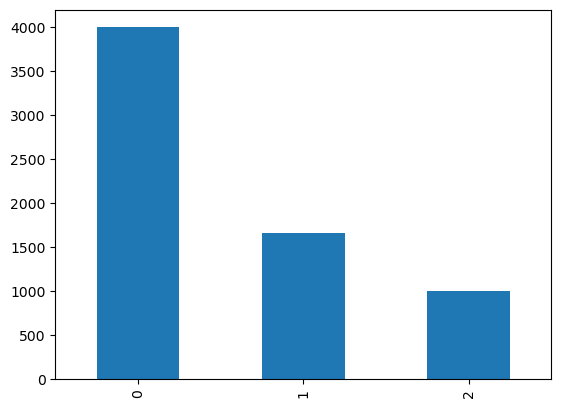

In [195]:
y_train.value_counts().plot(kind='bar')

In [196]:
y_test.value_counts()

0    1326
1     521
2     307
Name: Spending_Score, dtype: int64

# Modelling

In [197]:
model_list=['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest']
accuracy=[]
f1=[]
kappa=[]

## 1. Start with basic Logistic Regression

In [198]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

In [199]:
# initialise and fit the classifier
lg=LogisticRegression(max_iter=200, C=1.0)
lg.fit(X_train,y_train)

/Users/adi/opt/anaconda3/envs/ML_fall/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=200)

In [200]:
test_pred=lg.predict(X_test)
print("Accuracy:", lg.score(X_test,y_test))
accuracy.append(lg.score(X_test,y_test))


print("Cohens kappa: ",cohen_kappa_score(test_pred, y_test))
kappa.append(cohen_kappa_score(test_pred, y_test))

print("F1-score: ", f1_score(test_pred, y_test,average='macro'))
f1.append(f1_score(y_test,test_pred, average='macro'))

print(classification_report(y_test,test_pred, target_names=['Low', 'Average', 'High']))

Accuracy: 0.8026926648096564
Cohens kappa:  0.6463764644985843
F1-score:  0.7513132580530493
              precision    recall  f1-score   support

         Low       0.91      0.84      0.87      1326
     Average       0.64      0.83      0.73       521
        High       0.72      0.60      0.66       307

    accuracy                           0.80      2154
   macro avg       0.76      0.76      0.75      2154
weighted avg       0.82      0.80      0.81      2154



<AxesSubplot:>

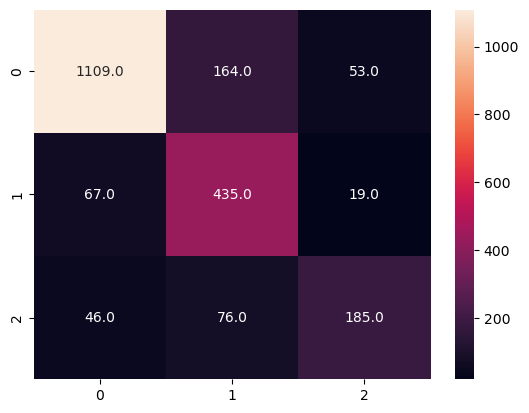

In [201]:
sns.heatmap(confusion_matrix(y_test,test_pred), annot=True, fmt="0.1f")

In [202]:
lg.coef_

array([[-4.48813563e-03, -2.37050505e-02, -5.06424149e-01,
         2.98493848e-01, -4.62901630e+00, -2.21697752e-01,
         4.01479166e-01,  3.57609766e-01,  6.14194678e-01,
        -2.60757786e-01,  8.31512089e-01,  2.21930558e-01,
         6.07054366e-01,  1.00500552e+00,  3.67524663e-01,
         1.07339986e+00,  9.69049532e-01,  3.68899471e-01,
         7.74154077e-01,  6.75449678e-01],
       [-1.66020686e-02, -8.33544304e-03,  2.49597050e-01,
         1.42477685e-01,  3.30401393e+00,  2.60604262e-01,
         2.99104308e-01,  4.27707773e-03,  2.04045520e-01,
        -1.81792099e+00, -1.09147633e+00, -1.86015558e-01,
        -2.18180411e+00, -1.27555067e+00, -2.36807090e-01,
        -4.08453566e-01, -2.98336824e-01, -1.50508082e-01,
        -2.18883655e-01, -5.29478777e-01],
       [ 2.10902042e-02,  3.20404935e-02,  2.56827099e-01,
        -4.40971533e-01,  1.32500237e+00, -3.89065098e-02,
        -7.00583474e-01, -3.61886844e-01, -8.18240199e-01,
         2.07867877e+00,  2.5

In [203]:
lg.feature_names_in_

array(['Age', 'Work_Experience', 'Family_Size', 'Gender_Male',
       'Ever_Married_Yes', 'Graduated_Yes', 'Profession_Doctor',
       'Profession_Engineer', 'Profession_Entertainment',
       'Profession_Executive', 'Profession_Healthcare',
       'Profession_Homemaker', 'Profession_Lawyer',
       'Profession_Marketing', 'Var_1_Cat_2', 'Var_1_Cat_3',
       'Var_1_Cat_4', 'Var_1_Cat_5', 'Var_1_Cat_6', 'Var_1_Cat_7'],
      dtype=object)

Performance is not the best, label imbalance is confusing the model 
Most false predictions for medium and high are 

# KNN

In [204]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn import preprocessing
from sklearn import neighbors
from sklearn.metrics import accuracy_score

In [205]:
y_test

0       0
1       1
3       2
5       2
6       0
       ..
2621    0
2622    0
2623    0
2625    2
2626    0
Name: Spending_Score, Length: 2154, dtype: int64

In [206]:

# initialise and fit the classifier 
knn=KNeighborsClassifier(n_neighbors=5) 
knn.fit(X_train,y_train)

KNeighborsClassifier()

In [207]:
test_pred=knn.predict(X_test)
print("Accuracy:", knn.score(X_test,y_test))
print("Cohens kappa: ",cohen_kappa_score(test_pred, y_test))

accuracy.append(knn.score(X_test,y_test))
kappa.append(cohen_kappa_score(test_pred, y_test))
f1.append(f1_score(y_test,test_pred, average='macro'))


print(classification_report(y_test,test_pred, target_names=['Low', 'Average', 'High']))

Accuracy: 0.754874651810585
Cohens kappa:  0.5455984887803207
              precision    recall  f1-score   support

         Low       0.85      0.85      0.85      1326
     Average       0.58      0.70      0.64       521
        High       0.64      0.44      0.52       307

    accuracy                           0.75      2154
   macro avg       0.69      0.66      0.67      2154
weighted avg       0.76      0.75      0.75      2154



<AxesSubplot:>

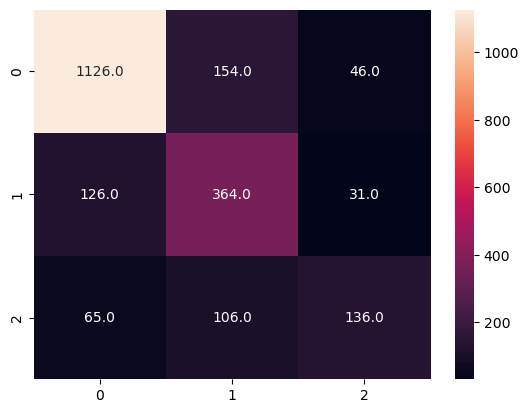

In [208]:
sns.heatmap(confusion_matrix(y_test,test_pred), annot=True, fmt="0.1f")

Did not expect KNN to work very well as a lot of the variables are categorical. It performs worse than logistic regression

# Decision Trees

In [209]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

In [210]:

# initialise and fit the classifier 
dt=DecisionTreeClassifier(criterion="entropy", max_depth=10, min_samples_split=50) 
dt.fit(X_train,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_split=50)

In [211]:
y_train.value_counts(normalize=True)

0    0.600000
1    0.249362
2    0.150638
Name: Spending_Score, dtype: float64

In [212]:
y_test

0       0
1       1
3       2
5       2
6       0
       ..
2621    0
2622    0
2623    0
2625    2
2626    0
Name: Spending_Score, Length: 2154, dtype: int64

In [213]:
test_pred=dt.predict(X_test)
print("Accuracy: %0.4f" %dt.score(X_test,y_test))
print("Cohens kappa: ",cohen_kappa_score(test_pred, y_test))

accuracy.append(dt.score(X_test,y_test))
kappa.append(cohen_kappa_score(test_pred, y_test))
f1.append(f1_score(y_test,test_pred, average='macro'))


print(classification_report(y_test,test_pred, target_names=['Low', 'Average', 'High']))

Accuracy: 0.8208
Cohens kappa:  0.6909828559195543
              precision    recall  f1-score   support

         Low       0.98      0.82      0.89      1326
     Average       0.63      0.92      0.75       521
        High       0.70      0.66      0.68       307

    accuracy                           0.82      2154
   macro avg       0.77      0.80      0.77      2154
weighted avg       0.86      0.82      0.83      2154



<AxesSubplot:>

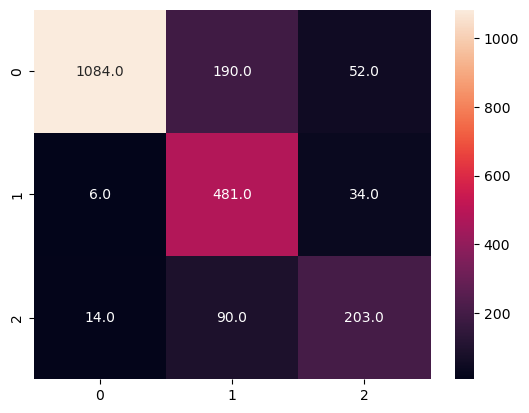

In [214]:
sns.heatmap(confusion_matrix(y_test,test_pred), annot=True, fmt="0.1f")

In [215]:
viz = dtreeviz(dt, X_train, y_train,
               target_name='Spending_Score',
               feature_names=X_train.columns,
               title="title")

viz


/Users/adi/opt/anaconda3/envs/ML_fall/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


# Random Forests

Since decision Trees work best, it is useful to try Random Forests

In [216]:
from sklearn.ensemble import RandomForestClassifier

In [217]:
model = RandomForestClassifier(n_estimators=100, random_state=1)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=1)

In [218]:
test_pred=model.predict(X_test)
print("Accuracy: %0.4f" %model.score(X_test,y_test))
print("Cohens kappa: ",cohen_kappa_score(test_pred, y_test))

accuracy.append(model.score(X_test,y_test))
kappa.append(cohen_kappa_score(test_pred, y_test))
f1.append(f1_score(y_test,test_pred, average='macro'))



print(classification_report(y_test,test_pred, target_names=['Low', 'Average', 'High']))

Accuracy: 0.8575
Cohens kappa:  0.7396660149898784
              precision    recall  f1-score   support

         Low       0.93      0.90      0.91      1326
     Average       0.77      0.81      0.79       521
        High       0.74      0.74      0.74       307

    accuracy                           0.86      2154
   macro avg       0.81      0.82      0.81      2154
weighted avg       0.86      0.86      0.86      2154



<AxesSubplot:>

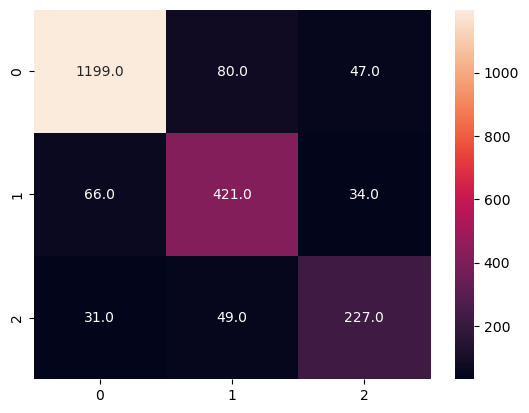

In [219]:
sns.heatmap(confusion_matrix(y_test,test_pred), annot=True, fmt="0.1f")

In [220]:
feature_info = pd.DataFrame({
    'feature_names':X_train.columns,
    'feature_importance':model.feature_importances_
})

feature_info.sort_values(by=['feature_importance'], ascending=False).head(5)

,feature_names,feature_importance
0,Age,0.276582
4,Ever_Married_Yes,0.229093
2,Family_Size,0.175737
1,Work_Experience,0.089332
9,Profession_Executive,0.057928


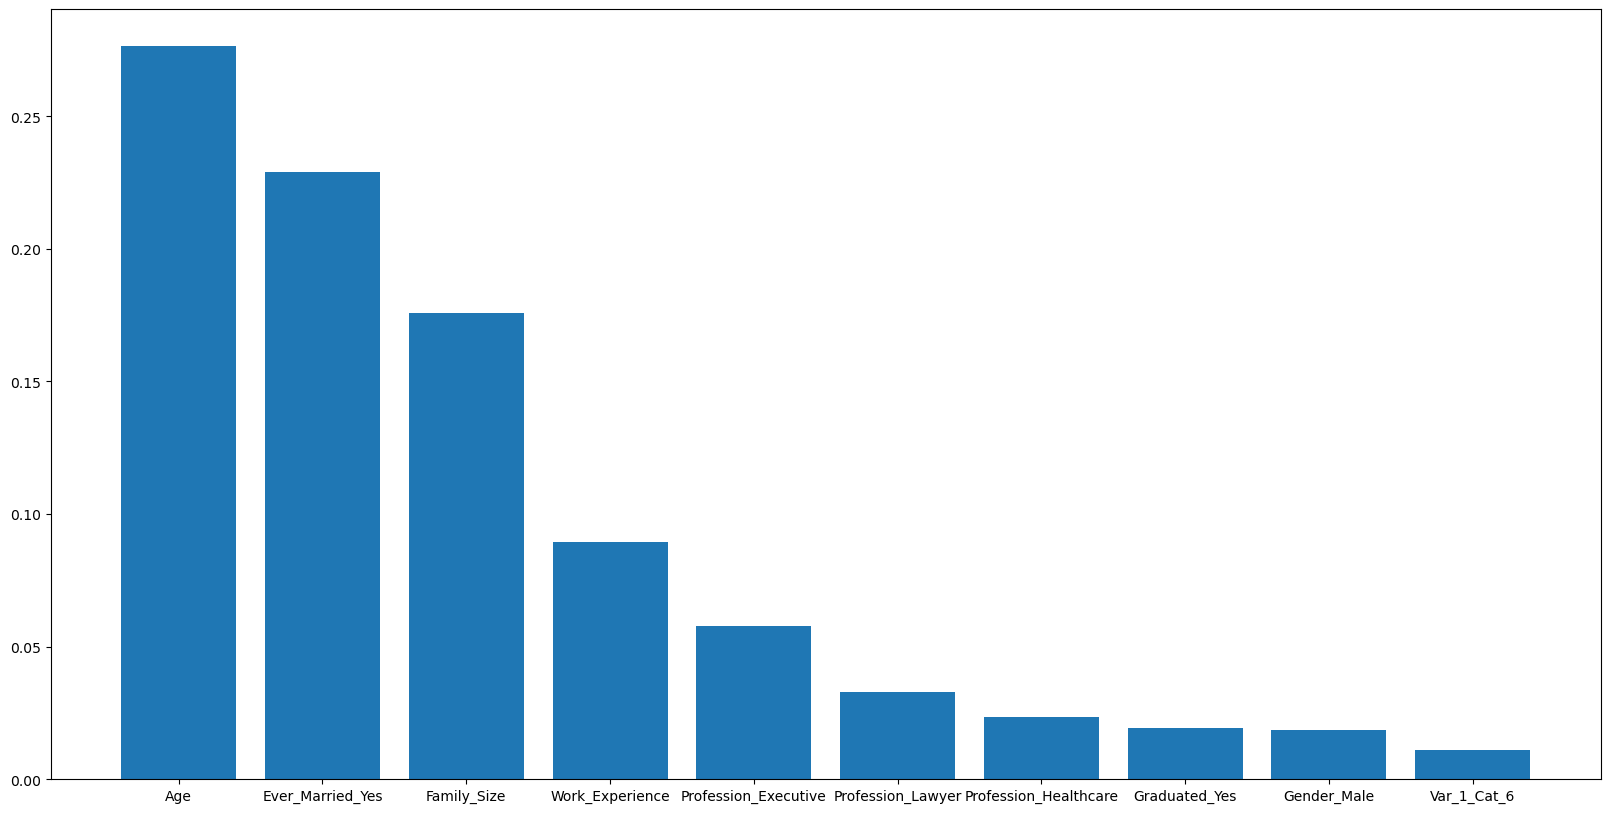

In [229]:
plt.figure(figsize=(20, 10))  

viz_data = feature_info.sort_values(by=['feature_importance'], ascending=False)

plt.bar(
    viz_data.feature_names[:10],
    viz_data.feature_importance[:10]
)

plt.show()

# Comparing Models

In [222]:
vals={"models":model_list,"Accuracy": accuracy, "Kappa":kappa, "F-1":f1}

In [223]:
mets=pd.DataFrame(vals)

Text(0, 0.5, 'Metrics')

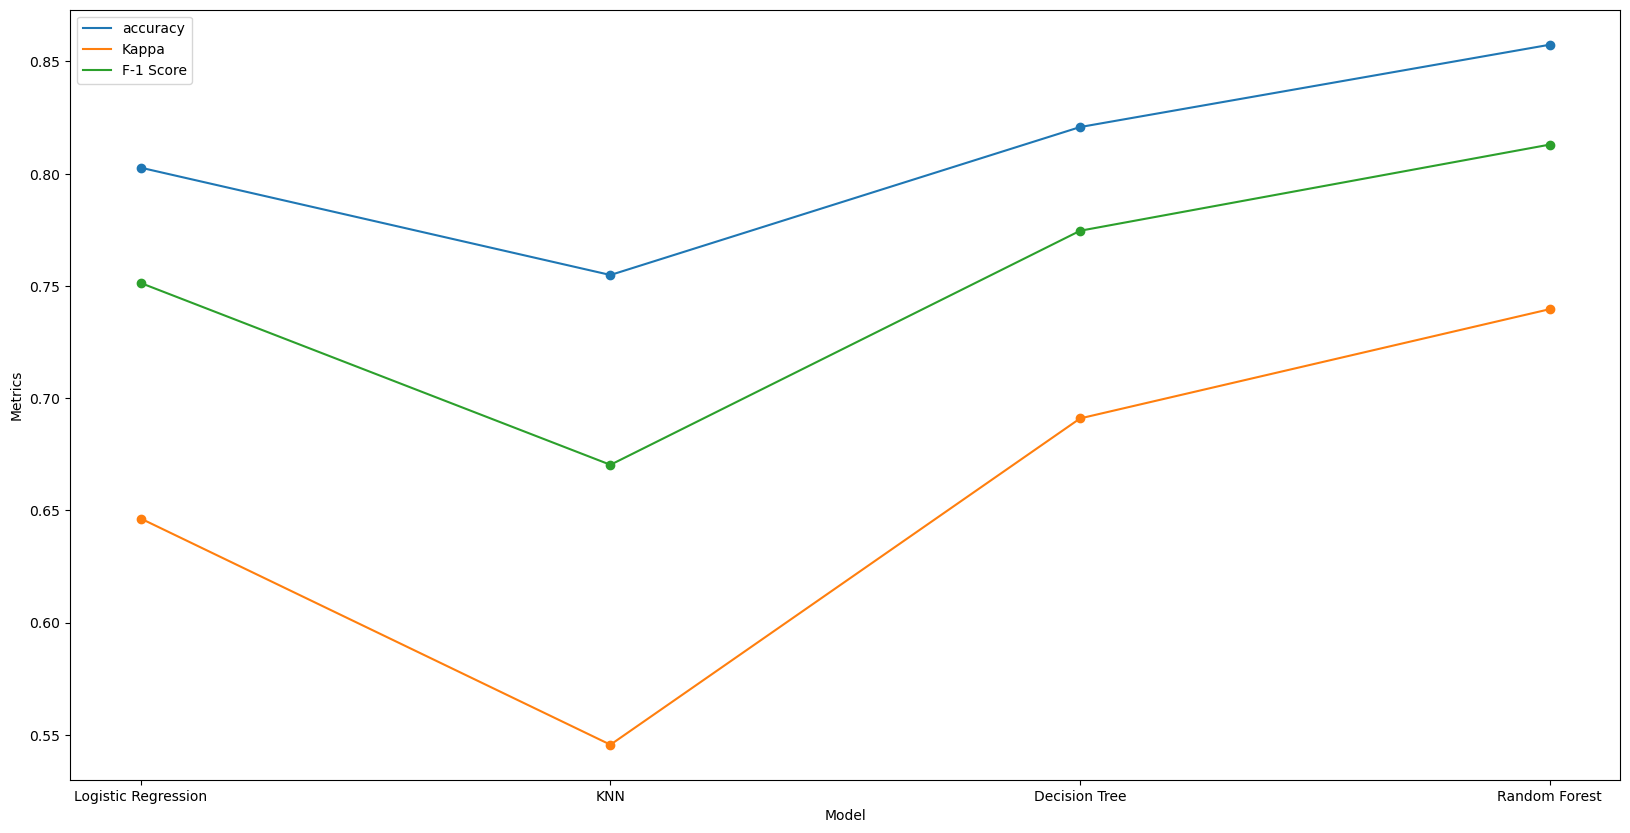

In [232]:
plt.figure(figsize=(20, 10))  
plt.plot(model_list,accuracy, label='accuracy')
plt.plot(model_list,kappa,label='Kappa')
plt.plot(model_list,f1,label="F-1 Score")
plt.scatter(model_list,accuracy)
plt.scatter(model_list,kappa)
plt.scatter(model_list,f1)
plt.legend()
plt.xlabel("Model")
plt.ylabel("Metrics")

Concluding remark:
Classification of spending score is a feasible direction for the company to take. In case thats data they were buying, they would no longer need to buy it as they could classify and obtain it. Also if they wanted to target customers according spending score, they can infer the customers spending capacity

# References


https://towardsdatascience.com/multi-class-metrics-made-simple-the-kappa-score-aka-cohens-kappa-coefficient-bdea137af09c

https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html

https://towardsdatascience.com/visualizing-data-with-pair-plots-in-python-f228cf529166

